In [22]:
import traceback

import requests
from bs4 import BeautifulSoup

import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

In [24]:
try:
    import pygmt
except:
    traceback.print_exc()

Traceback (most recent call last):
  File "C:\Users\arasyidi\AppData\Local\Temp\ipykernel_32732\653858203.py", line 2, in <module>
    import pygmt
  File "d:\0_amri_local\99_personal\eq_map\.venv\Lib\site-packages\pygmt\__init__.py", line 29, in <module>
    with clib.Session() as lib:
  File "d:\0_amri_local\99_personal\eq_map\.venv\Lib\site-packages\pygmt\clib\session.py", line 210, in __enter__
    self.create("pygmt-session")
  File "d:\0_amri_local\99_personal\eq_map\.venv\Lib\site-packages\pygmt\clib\session.py", line 357, in create
    c_create_session = self.get_libgmt_func(
                       ^^^^^^^^^^^^^^^^^^^^^
  File "d:\0_amri_local\99_personal\eq_map\.venv\Lib\site-packages\pygmt\clib\session.py", line 309, in get_libgmt_func
    self._libgmt = load_libgmt()
                   ^^^^^^^^^^^^^
  File "d:\0_amri_local\99_personal\eq_map\.venv\Lib\site-packages\pygmt\clib\loading.py", line 59, in load_libgmt
    raise GMTCLibNotFoundError("\n".join(error_msg))
pygmt.exce

In [13]:
# Send a GET request to the web page
url = "https://www.bmkg.go.id/gempabumi-dirasakan.html"
response = requests.get(url)

# Create a BeautifulSoup object to parse the HTML content
soup = BeautifulSoup(response.content, 'html.parser')

# Find the desired elements on the page
table = soup.find('table', {'class': 'table table-hover table-striped'})

# Extract the table headers
headers = [header.get_text(strip=True) for header in table.find_all('th')]

# Extract the table rows
rows = table.find_all('tr')
data = []
for row in rows:
    columns = row.find_all('td')
    row_data = [column.get_text(strip=True) for column in columns]
    data.append(row_data)

# Create a pandas DataFrame
df = pd.DataFrame(data, columns=headers).iloc[1:,1:]

# Convert the "waktu gempa" column to datetime format
df["Waktu Gempa"] = pd.to_datetime(df["Waktu Gempa"], format="%d/%m/%Y%H:%M:%S WIB")

# Convert 'magnitudo' column to float
df['Magnitudo'] = pd.to_numeric(df['Magnitudo'], errors='coerce')

# Extract numerical part from "Kedalaman" column and convert to float
df['Kedalaman'] = df['Kedalaman'].str.extract(r'(\d+)', expand=False).astype(float)

# Split the "Lintang - Bujur" column into four columns
df[['Lintang_Value', 'Lintang_String', 'Bujur_Value', 'Bujur_String']] = df['Lintang - Bujur'].str.split(expand=True)

# Create a new column "Latitude" based on Lintang_Value and Lintang_String
df['Latitude'] = df['Lintang_Value'].astype(float)
df.loc[df['Lintang_String'] == 'LS', 'Latitude'] *= -1

# Create a new column "Longitude" based on Bujur_Value and Bujur_String
df['Longitude'] = df['Bujur_Value'].astype(float)
df.loc[df['Bujur_String'] == 'BB', 'Longitude'] *= -1

# Drop the original "Lintang - Bujur" column
df.drop(['Lintang - Bujur', 'Lintang_Value', 'Lintang_String', 'Bujur_Value', 'Bujur_String', 'Dirasakan (Skala MMI)'], axis=1, inplace=True)

# Create a GeoDataFrame with Longitude and Latitude as the geometry
geometry = gpd.points_from_xy(df['Longitude'], df['Latitude'])
gdf = gpd.GeoDataFrame(df, geometry=geometry)

gdf = gdf.rename(columns = {_:_.lower().replace(" ","_") for _ in gdf.columns})
gdf.drop(['longitude', 'latitude'], axis=1, inplace=True)

gdf.head(3)

,waktu_gempa,magnitudo,kedalaman,geometry
1,2023-06-05 23:13:24,4.4,11.0,POINT (118.28000 0.82000)
2,2023-06-05 11:57:47,3.3,10.0,POINT (120.74000 1.23000)
3,2023-06-04 20:48:39,4.6,10.0,POINT (107.89000 -8.43000)


<Axes: >

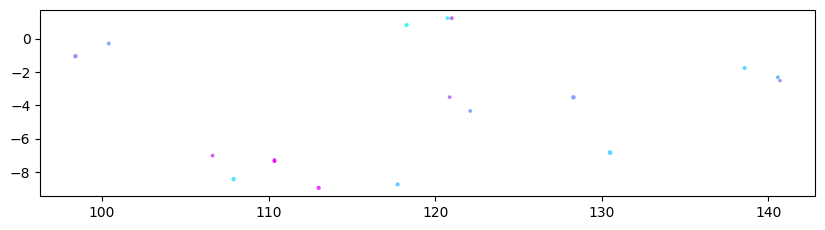

In [15]:
# Plot the GeoDataFrame with a basemap
fig, ax = plt.subplots(figsize=(10, 10))

gdf.plot(ax=ax, markersize=gdf['magnitudo'], c=gdf['kedalaman'], cmap='cool', alpha=0.7)